# `Challenge Deep Learning`

## `Consigne`

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles.

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante :
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test.

Le notebook sera déposé sur la plateforme moodle du cours.

In [256]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from PIL import Image
import random

In [259]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import torch

ModuleNotFoundError: No module named 'torch'

## `Pré-traitement des données`


In [237]:
import pathlib

path = "datasets/mushrooms"
dset_dir = pathlib.Path(path)
image_count = len(list(dset_dir.glob('*/*.jpg')))
print(f"Nombre d'images : {image_count}")

Nombre d'images : 1643


In [238]:
batch_size = 16
img_height = 224
img_width  = 224

seed = 4785

In [239]:
train_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1643 files belonging to 3 classes.
Using 1315 files for training.


In [240]:
val_dset = tf.keras.utils.image_dataset_from_directory(
    dset_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1643 files belonging to 3 classes.
Using 328 files for validation.


In [241]:
class_names = train_dset.class_names
print(class_names)

['amanita', 'crimini', 'oyster']


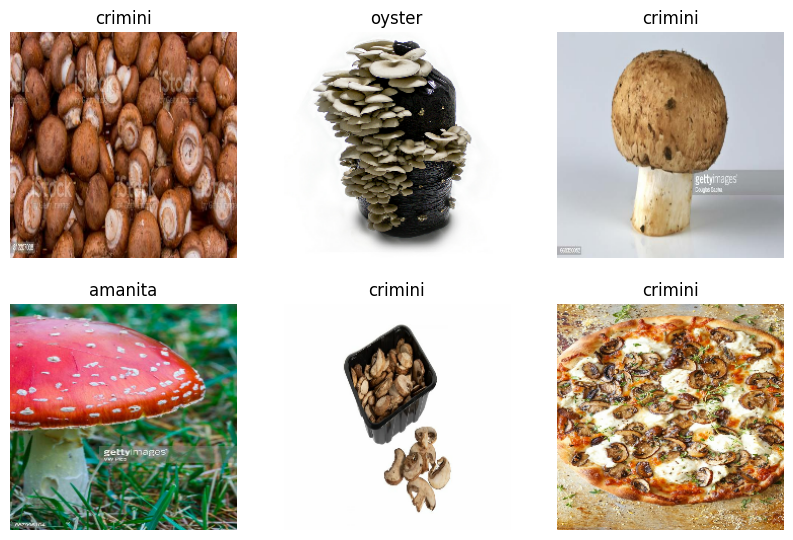

In [242]:
plt.figure(figsize=(10,10))
for images, labels in train_dset.take(1):
    for i in range(6):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# `Modèle de réseaux de neurones`


## ``ResNet50``
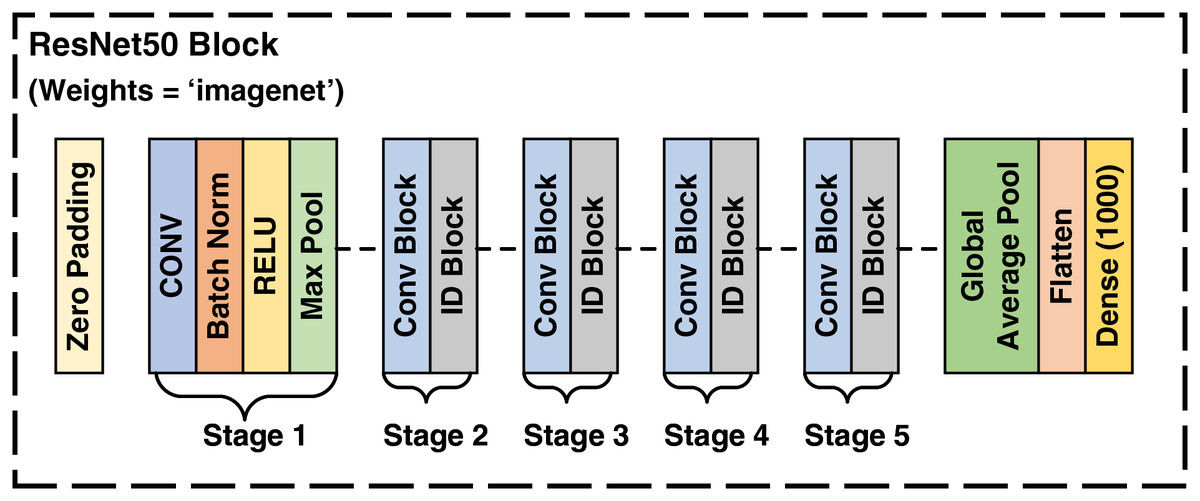

In [243]:
AUTOTUNE = tf.data.AUTOTUNE

train_dset = train_dset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dset = val_dset.cache().prefetch(buffer_size=AUTOTUNE)

print(train_dset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [244]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_dset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [245]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3)
])

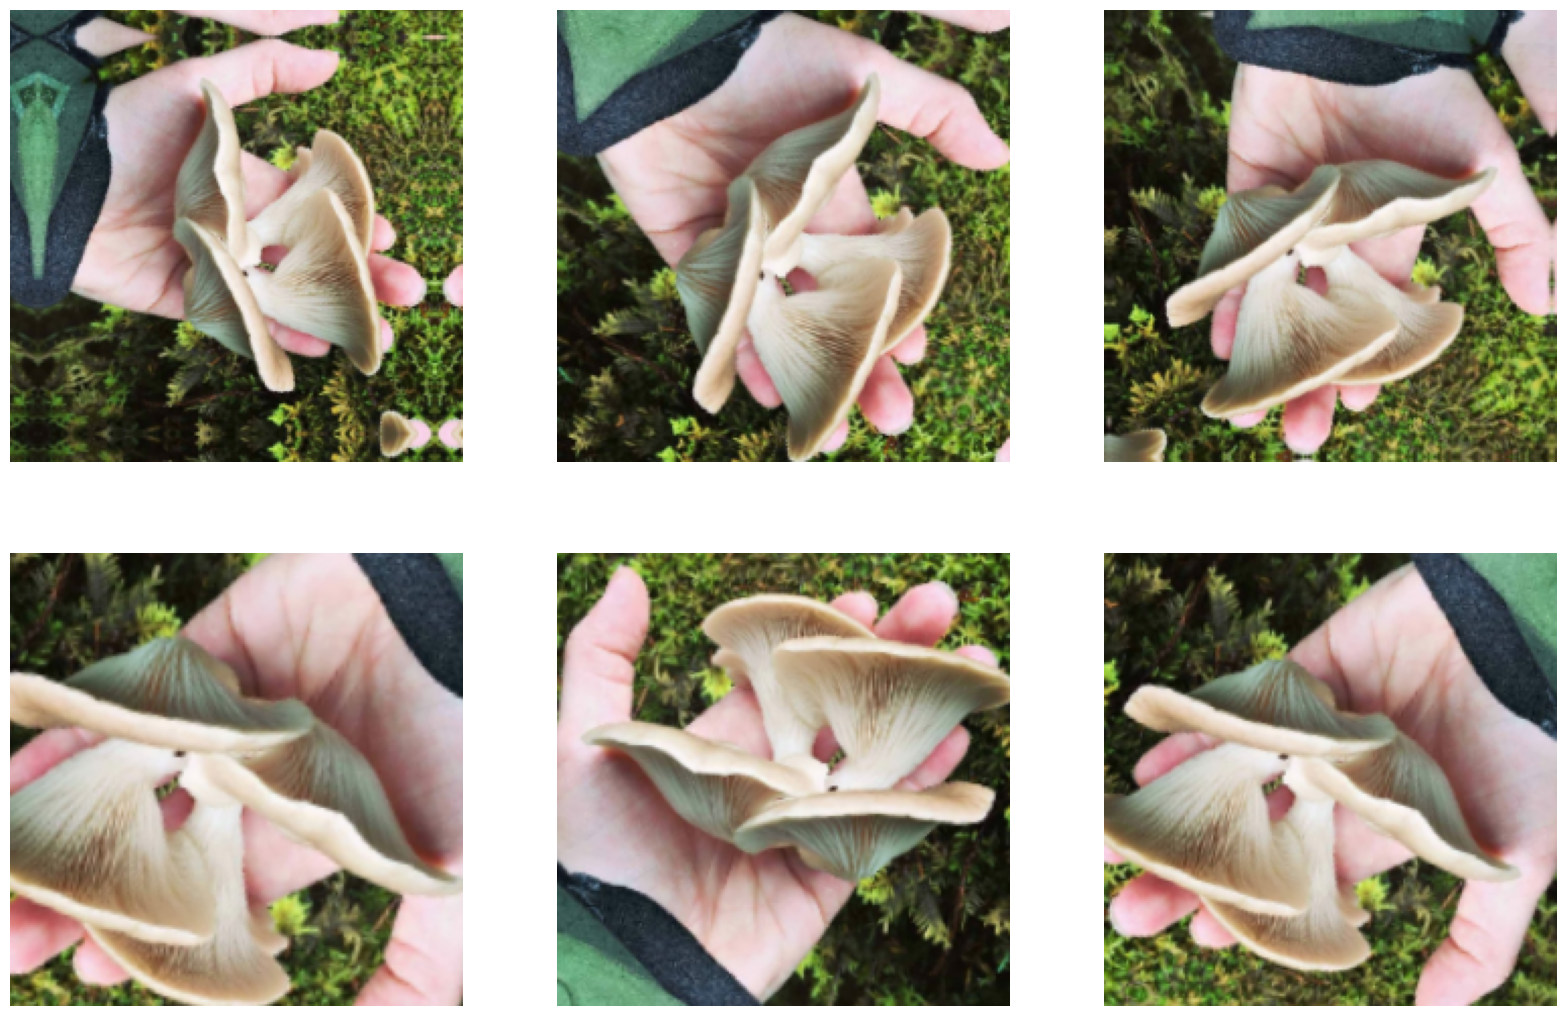

In [246]:
plt.figure(figsize=(20,20))
for images, _ in train_dset.take(1):
    for i in range(6):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [247]:
num_classes = len(class_names)

resnet_model = ResNet50(weights="imagenet")

last_layer = resnet_model.get_layer("avg_pool")
resnet_layers = Model(inputs=resnet_model.inputs, outputs=last_layer.output)

model = Sequential()
model.add(data_augmentation)
model.add(resnet_layers)
model.add(Dense(num_classes))

resnet_layers.trainable = True

for layer in resnet_layers.layers[:100]:
    layer.trainable = False

In [248]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_29 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_63 (Functional)      │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 19,459,075 (74.23 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [251]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Model(ResNet50).keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                              mode='max', cooldown=2, patience=3, min_lr=0)


In [295]:
epochs = 10

history = model.fit(
    train_dset,
    validation_data=val_dset,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - accuracy: 0.9877 - loss: 0.0435
Epoch 1: val_accuracy did not improve from 0.94512
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 973ms/step - accuracy: 0.9877 - loss: 0.0434 - val_accuracy: 0.9299 - val_loss: 0.2627 - learning_rate: 5.0000e-05
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.9830 - loss: 0.0404
Epoch 2: val_accuracy did not improve from 0.94512
83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9831 - loss: 0.0403 - val_accuracy: 0.9238 - val_loss: 0.2878 - learning_rate: 5.0000e-05
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.9973 - loss: 0.0178
Epoch 3: val_accuracy improved from 0.94512 to 0.95122, saving model to Model(ResNet50).keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9973 - loss: 0.0179 - val_accuracy: 0.9512 - val_loss: 0.2493 - learning_rate: 5.0000e-05
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9903 - loss: 0.0214
Epoch 4: val_accuracy did no

In [380]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_images_grid_predicted_keras(dataset, model, classes, num_images=15):
    grid_size = int(np.sqrt(num_images))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()

    images_displayed = 0

    for batch_images, batch_labels in dataset:
        for img, label in zip(batch_images, batch_labels):
            if images_displayed >= num_images:
                break

            label = int(label.numpy())
            true_label = classes[label]

            input_img = tf.expand_dims(img, axis=0)
            pred = model.predict(input_img, verbose=0)
            pred_label = classes[np.argmax(pred)]

            color = "green" if pred_label == true_label else "red"
            ax = axes[images_displayed]
            ax.imshow(tf.keras.utils.array_to_img(img))
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=color)
            ax.axis("off")

            images_displayed += 1

        if images_displayed >= num_images:
            break

    plt.tight_layout()
    plt.show()

Found 15 files belonging to 3 classes.


IndexError: index 9 is out of bounds for axis 0 with size 9

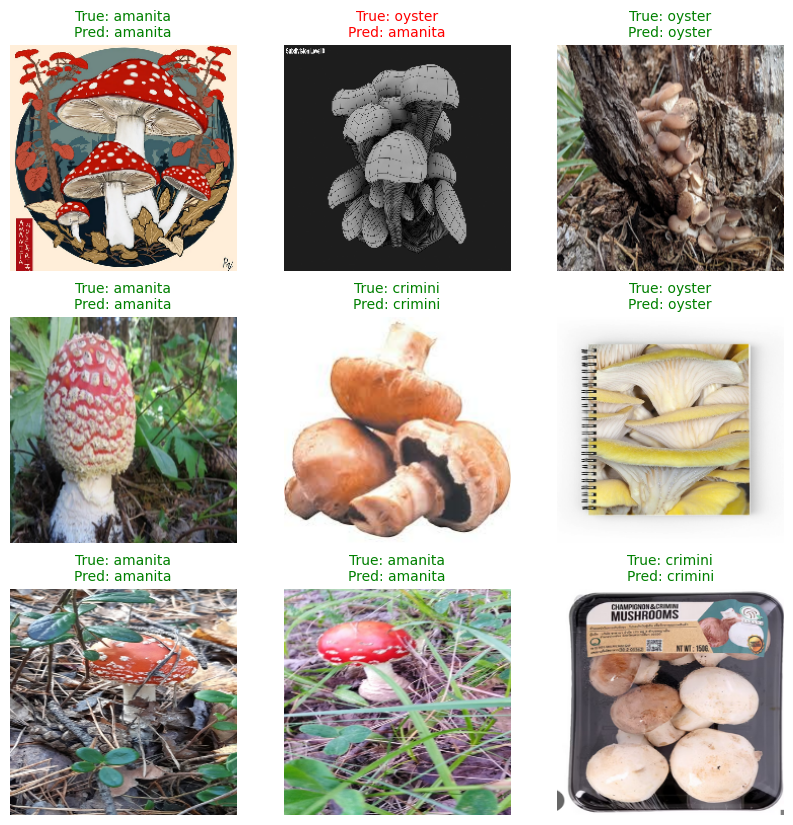

In [381]:
path = "tests"
test_dset_dir = pathlib.Path(path)

test_dset = tf.keras.utils.image_dataset_from_directory(
    test_dset_dir,
    labels="inferred",
    label_mode="int",
    seed=seed,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

plot_images_grid_predicted_keras(test_dset, model, classes=class_names)

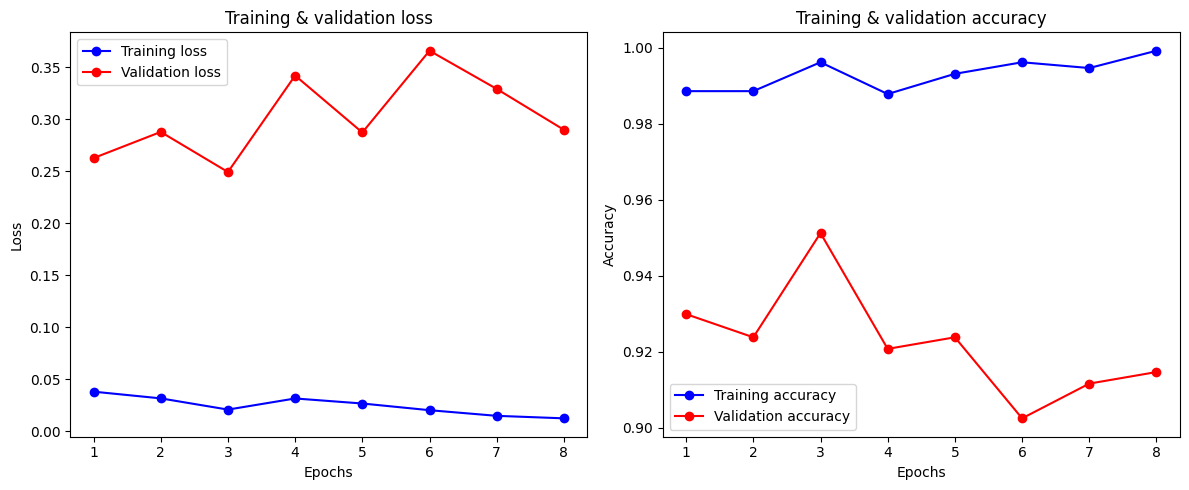

In [388]:
def plot_learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Tracer la perte
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training & validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Tracer la précision
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training & validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)
